In [1]:
# Imports used in the assigmnent
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import csv
import seaborn as sns

In [2]:
# lodaing the dataset
input_data = pd.read_csv("nyc_taxis.csv")
input_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


## Outlier Detection
### Lets visualize the passanger count using a box and whisker plot
A box and whisker plot can easily detect outliers. An outlier is an observation that is numerically distant from the rest of the data, so any point located outside the whiskers is an outlier

<AxesSubplot:xlabel='passenger_count'>

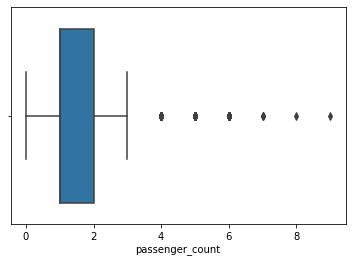

In [3]:
sns.boxplot(x=input_data['passenger_count'])

In [4]:
before_len = len(input_data)
df = input_data[input_data.passenger_count <= 6]
after_len = len(df)
print(before_len - after_len)

5


According to the official uber website (https://www.uber.com/us/en/ride/how-it-works/uber-ride-types/), the uberX can carry up to 4 people and the uberSUV can carry up to 6 people, both without the driver. All passengers with a number greater than 6 are regarded outliers and are excluded based on domain knowledge and a box-and-whisker plot. Outliers 5 and 6 will be kept because uberSUV can cater for them. Only 5 rows were removed using the passenger count feature.

### Lets visualize the trip duration given using log-scale distplot in sns
The durations of the trips are measured in seconds, with some lasting more than 350000 seconds, far longer than others lasting less than 1000 seconds. Such long trips are making all another trip invisible in the histogram on plain scale => We go ahead with the log scale.  The log scale distribution plot in sns will be used to ensure that the trip duration seconds scale to the same numbers with no major gaps between them. As a result, plotting the trip durations on a regular scale won't work, therefore we'll use a log scale instead. 

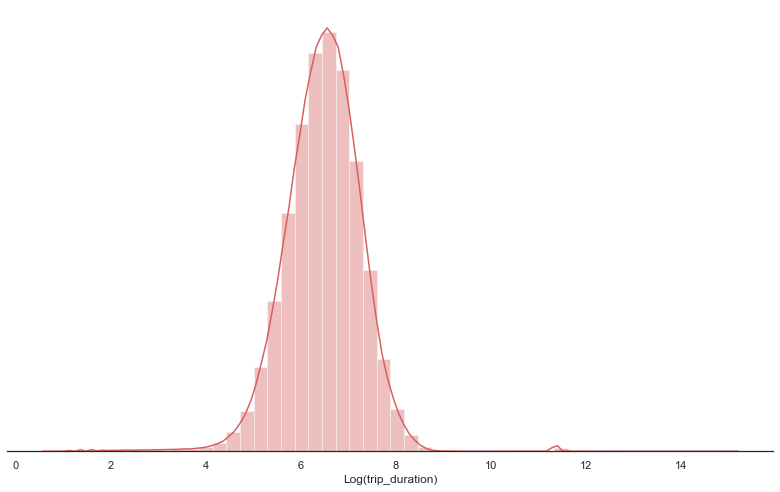

In [5]:
%matplotlib inline
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(df['trip_duration'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

In [6]:
series = df['trip_duration']
max(series)

3526282

It is clear with the above histogram and kernel density plot that the trip-durations assume a Normal Distrbution and few trips have very large duration, like 3526282 seconds which is approximately 1000 hours (It is safe to make the assumption that these trips are not from the inner city but city to city), while most of the trips are e^4 = 1 minute to e^8 ~ 60 minutes. Consider below where we check the latitude and longitude distributions to have know the coordinates of all trips happening around New York City.

### Lets visualize the latitude and longitude coordinates

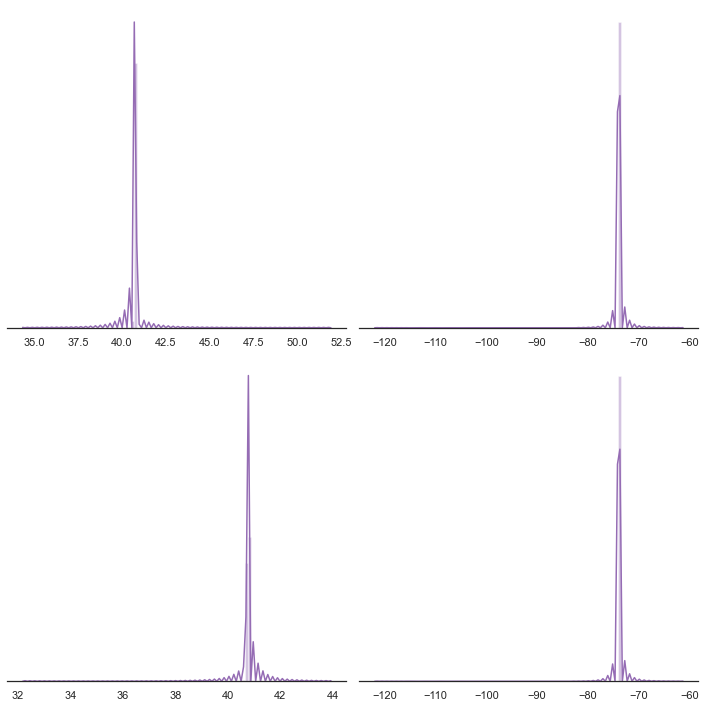

In [7]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="m", bins = 100, ax=axes[0,0])
sns.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="m", bins =100, ax=axes[0,1])
sns.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="m", bins =100, ax=axes[1, 0])
sns.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="m", bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

The latitude and longitude features are used to construct the distribution plots above. The pick and drop latitudes are concentrated about 40 to 41 degrees, while the longitude is around -74 to -73 degrees, as seen in the graphs above. We don't get a histogram-like plot from the plots above, indicating that outliers affect the sns distribution function. Large trips will be eliminated by setting a limit from 40 to 41 degrees latitude and -74 to -73 degrees longitude, respectively.

In [8]:
# Eliminating the outliers using with a lower and upper bound
before_drop = len(df)
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df = df.loc[(df.dropoff_latitude> 40) & (df.dropoff_latitude < 42)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
print(before_drop - len(df))

4656


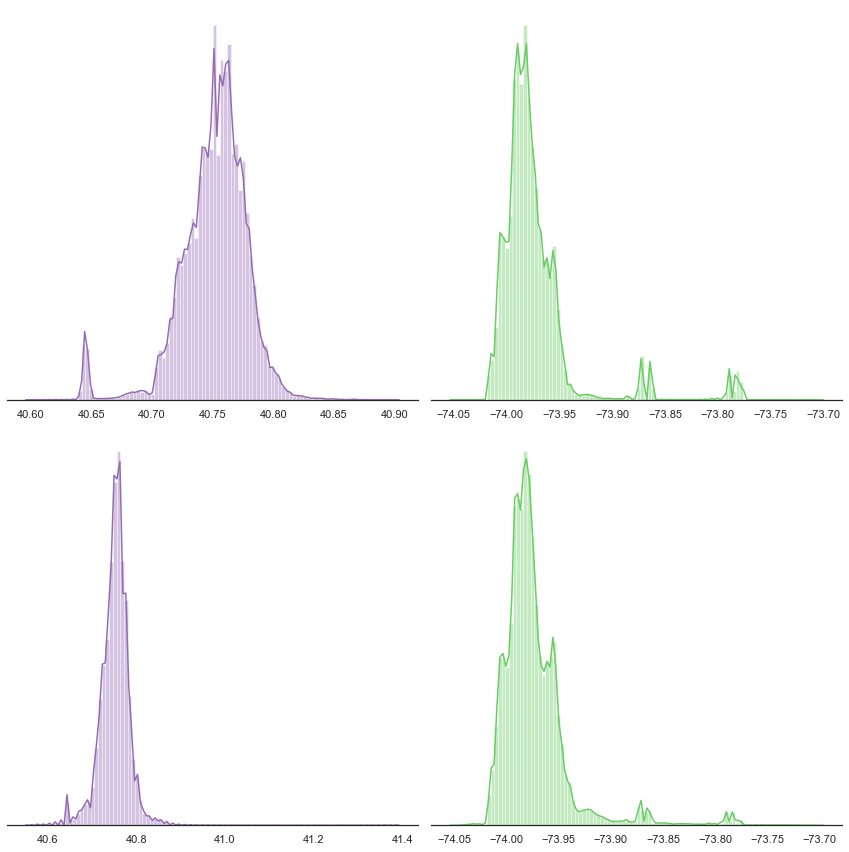

In [9]:
train_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

The latitude pickup and dropoff range have been reduced from 40.6 to 40.9, while the longitude pickup and dropoff range has been reduced from -74.05 to -73.7. This assures that the trips are focused solely on the same place (New York City).

# Feature Generation

In [10]:
"""function to calculate haversine distance between two co-ordinates"""
def haversine_(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

"""function to calculate manhatten distance between pick_drop"""
def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

In [11]:
# Feature generation

# Distance
train_data_new.loc[:,'distance_of_trip'] = manhattan_distance_pd(train_data_new['pickup_latitude'].values,
                                                             train_data_new['pickup_longitude'].values, 
                                                             train_data_new['dropoff_latitude'].values, 
                                                             train_data_new['dropoff_longitude'].values)

# Day of the week
train_data_new['pickup_datetime'] = pd.to_datetime(train_data_new.pickup_datetime)
train_data_new.loc[:, 'day_of_week'] = train_data_new['pickup_datetime'].dt.dayofweek

# Average speed of the trip
train_data_new['Speed_of_trip'] = ((train_data_new.distance_of_trip/train_data_new.trip_duration)*1000)

train_data_new

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_of_trip,day_of_week,Speed_of_trip
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.735433,0,3.814139
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2.430506,6,3.665922
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,8.203575,1,3.862323
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.661331,2,3.872567
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.199457,5,2.757372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,1.665895,4,2.141253
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,8.058580,6,12.303176
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,10.645646,4,13.934091
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,1.521850,1,4.080026


## Time-based questions

### Days of the week plot
According to the bar-graph plot above, day 4 is the most popular day.

<AxesSubplot:>

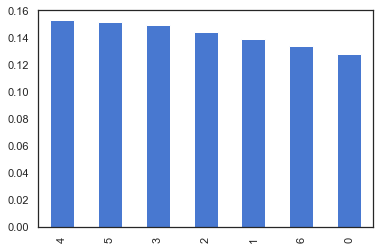

In [12]:
train_data_new['day_of_week'].value_counts(normalize=True).plot.bar()

In [13]:
train_data_new.loc[:, 'hour'] = train_data_new['pickup_datetime'].dt.hour
train_data_new

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_of_trip,day_of_week,Speed_of_trip,hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.735433,0,3.814139,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2.430506,6,3.665922,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,8.203575,1,3.862323,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.661331,2,3.872567,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.199457,5,2.757372,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,1.665895,4,2.141253,13
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,8.058580,6,12.303176,7
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,10.645646,4,13.934091,6
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,1.521850,1,4.080026,15


### Hours of the Week plot (for each day of the week)

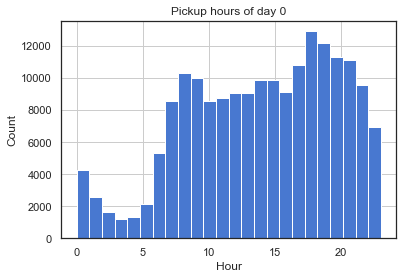

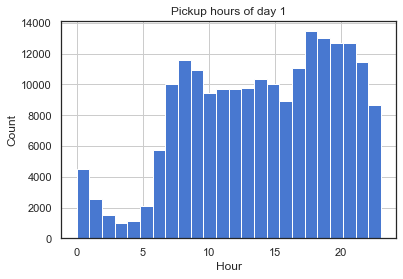

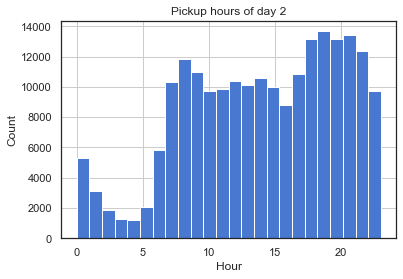

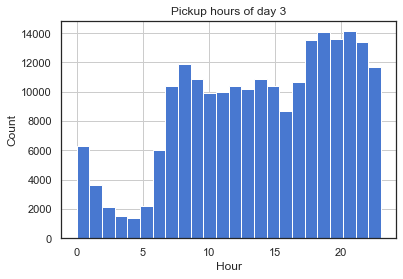

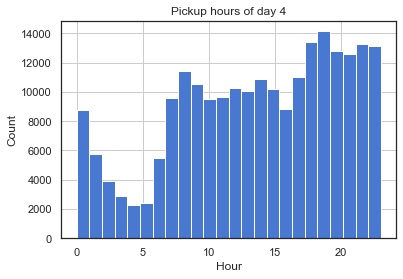

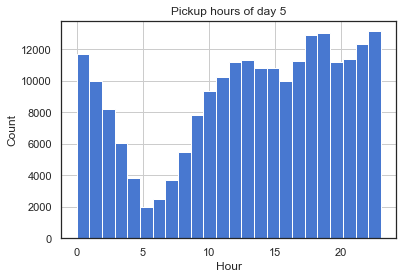

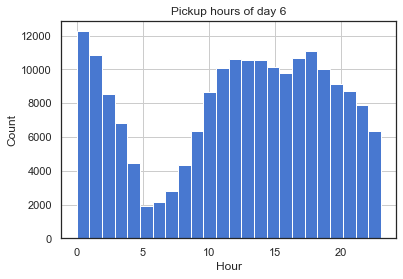

In [14]:
# Plotting pick hours for each day of the week 
import pylab as plt
from pandas import *
gk = train_data_new.groupby('day_of_week')
for i in range(7):
    day = gk.get_group(i)
    day["hour"].hist(bins = 24)
    plt.title("Pickup hours of day " + str(i))
    plt.xlabel("Hour")
    plt.ylabel("Count")
    plt.show()

The most popular hour of day 0 is 18. This might be because this is the hour when people come back from visiting thier loved ones or from church. This day might be Sunday(0).

The most popular hour of day 1 is 18. This might be because this is the knock off hour of most people. This day might be Monday(0).

The most popular hour of day 2 is 19. This might be because this is the knock off hour of most people. This day might be Tuesday(0).

The most popular hour of day 3 is 21. This might be because this is the knock off hour of most people. This day might be Wednesday(0).

The most popular hour of day 4 is 19. This might be because this is the knock off hour of most people. This day might be Thursday(0).

The most popular hour of day 5 is 23. People always prefer sgoing out for dinner dates after work on Fridays. This day might be Friday(0).

The most popular hour of day 6 is 1. This might be because of people going to church or visiting family. This day is most probably Saturday(0). 

### Box-Plots

#### Interpretation
Most popular plots to check the distribution of variables
box covers data from second and third quadrant and rest is shorn by bars
Dots on the both side of bars shows outlier

3526282


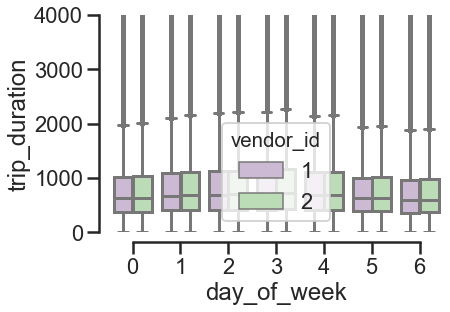

In [15]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="day_of_week", y="trip_duration", hue="vendor_id", data=train_data_new, palette="PRGn")
plt.ylim(0, 4000)
sns.despine(offset=10, trim=True)
print(train_data_new.trip_duration.max())

The boxplot above shows that the average travel duration on Sunday (0) and Saturday (6) (Weekends) is less than 2000 seconds, whereas the average travel trip duration on Mondays through Fridays (Weekdays) exceeds 2000 seconds, i.e. roughly 33.33 minutes. This might imply that people travel longer distances on weekdays compared to weekends because of the longer duration from the box-plot. Traffic might also be a cause of the longer duration for weekdays. Time taken by Monday, Tuesday, Wednesday, Thursday and Friday (Weekdays) are greater than rest of the days.

### line-plot
Simple lineplots can explain how the trip duration is changing with time for different days of week.

In [16]:
!pip install seaborn==0.9.0
import seaborn as sns

C:\Users\khumo\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


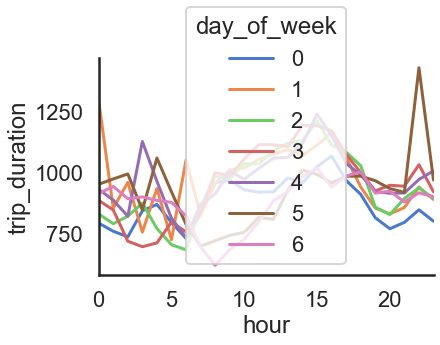

In [17]:
summary_hour_duration = pd.DataFrame(train_data_new.groupby(['day_of_week','hour'])['trip_duration'].mean())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="hour", unit = "unit", condition="day_of_week", value="trip_duration")
sns.despine(bottom = False)